In [1]:
import warnings
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import PIL.Image as Image
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
warnings.filterwarnings("ignore")

2024-08-10 00:14:57.994331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 00:14:58.010031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 00:14:58.014746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 00:14:58.025994: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 00:14:59.110860: W tensorflow/compiler/tf2

In [2]:
dataset_directory = '/home/kaeya/Documents/machine learning/rice/data'

# List of categories (subfolder names) for rice types
categories = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Initialize lists to store filenames and categories
filenames = []
category_labels = []

# Iterate through the categories
for category in categories:
    # Path to the current category folder
    category_folder = os.path.join(dataset_directory, category)
    # Check if the folder exists
    if os.path.exists(category_folder):
        # List all filenames in the category folder
        category_filenames = os.listdir(category_folder)
        # Append filenames and corresponding category labels
        filenames.extend([os.path.join(category, filename) for filename in category_filenames])
        category_labels.extend([category] * len(category_filenames))
    else:
        print(f"Folder '{category_folder}' does not exist")

# Create DataFrame
df = pd.DataFrame({
    'filename': filenames,
    'category': category_labels
})

In [3]:
filenames = np.array(filenames)
labels = np.array(category_labels)

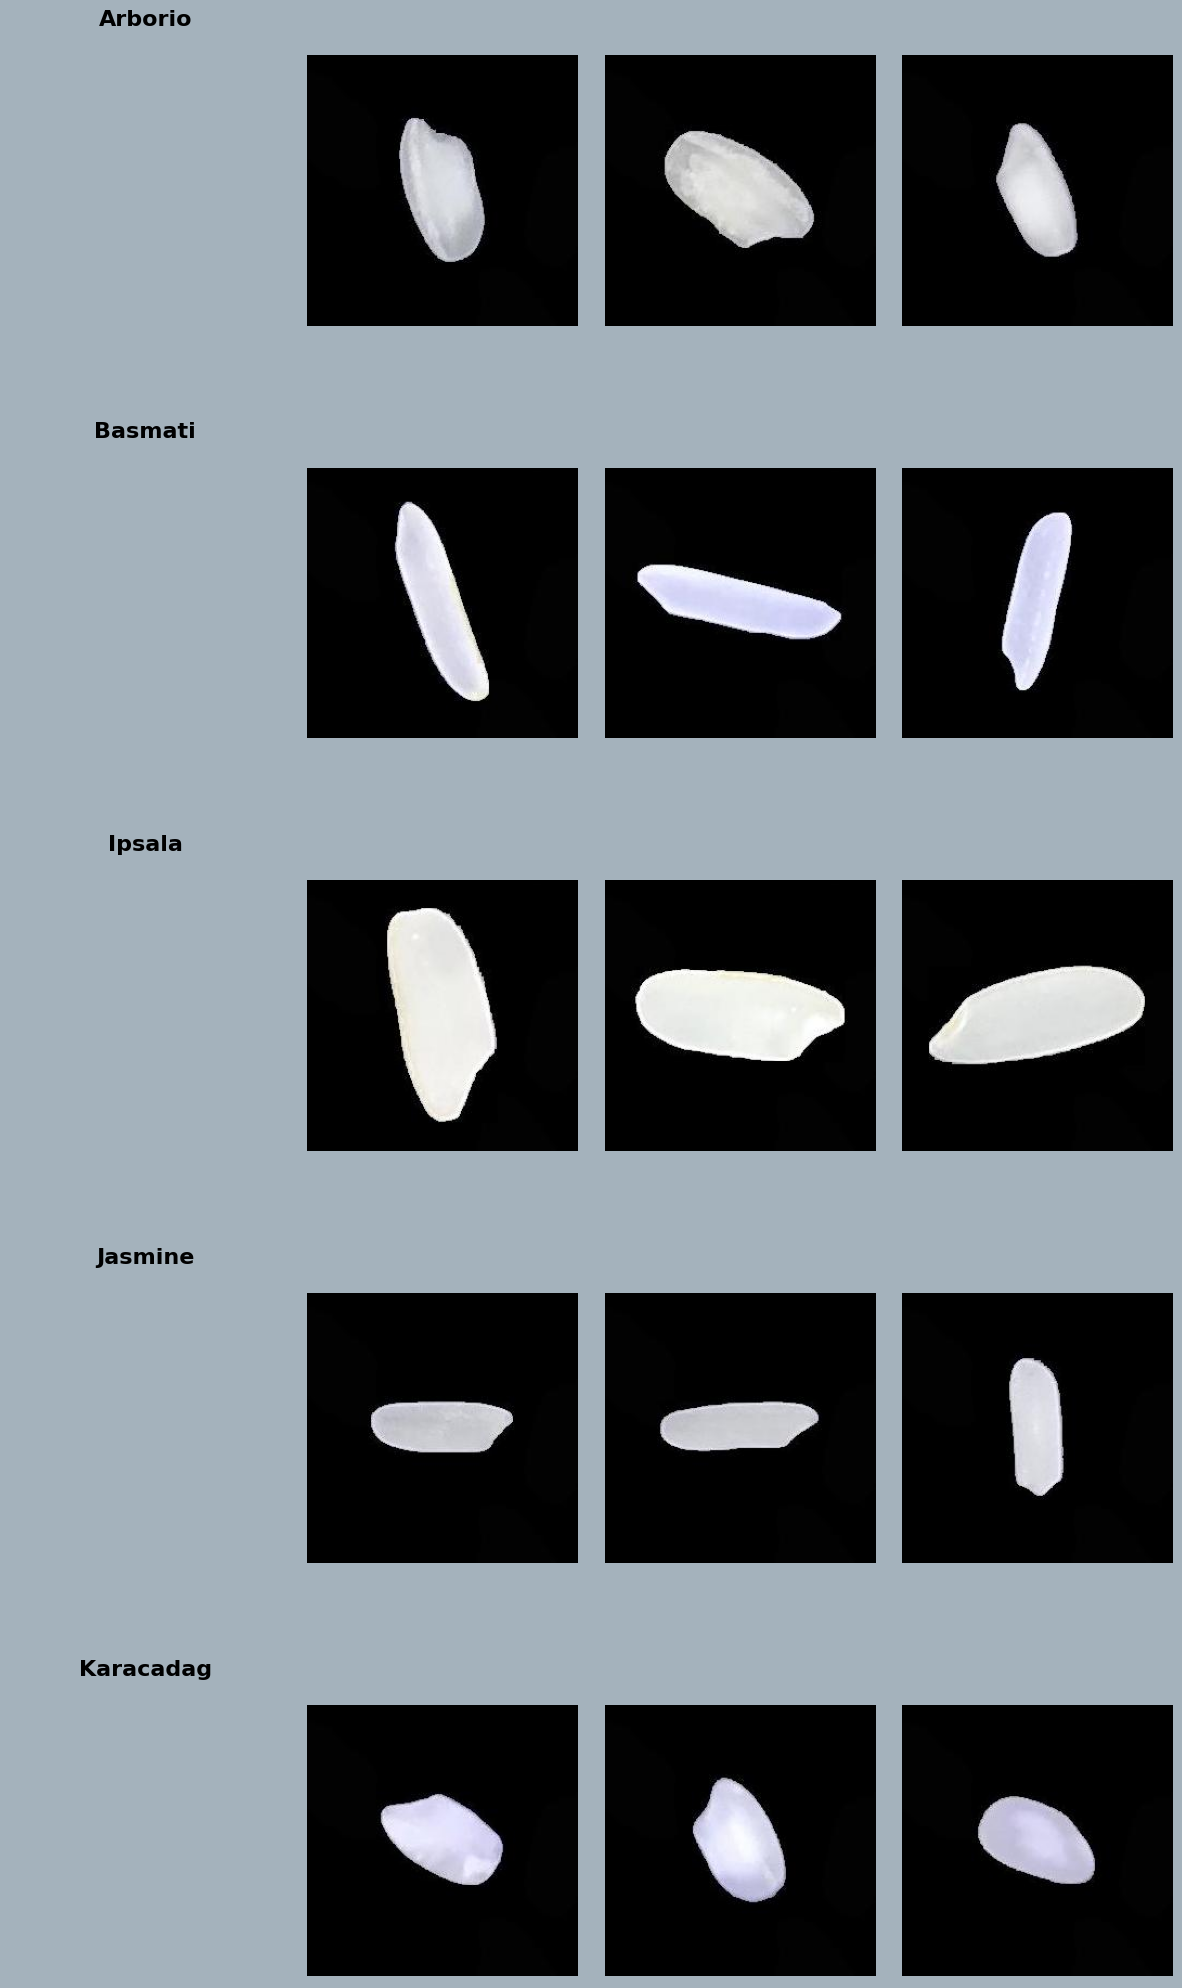

In [4]:
def visualize_images_from_categories(categories_paths, num_images=3):
    num_categories = len(categories_paths)
    
    # Create a figure with enough subplots for images and titles
    fig, axes = plt.subplots(num_categories, num_images + 1, figsize=(15, num_categories * 5), facecolor='#A4B2BC')
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()
    
    for i, (category, path) in enumerate(categories_paths.items()):
        image_filenames = os.listdir(path)
        num_images_to_show = min(num_images, len(image_filenames))
        
        # Title on the left side
        title_ax_left = axes[i * (num_images + 1)]
        title_ax_left.axis('off')
        title_ax_left.set_title(category, fontsize=16, fontweight='bold', loc='center', pad=20)
        
        # Display images for the current category
        for j in range(num_images_to_show):
            image_filename = image_filenames[j]
            image_path = os.path.join(path, image_filename)
            image = mpimg.imread(image_path)
            
            ax = axes[i * (num_images + 1) + j + 1]
            ax.imshow(image)
            ax.axis('off')  # Turn off axis
        
        # Hide any unused subplots in the current row
        for k in range(num_images_to_show + 1, num_images + 1):
            axes[i * (num_images + 1) + k].axis('off')
    
    # Remove any unused subplots (in case num_images is less than the maximum number of images per category)
    for j in range(num_categories * (num_images + 1), len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout and display the figure
    plt.subplots_adjust(hspace=0.5, wspace=0.1)
    plt.show()

# Specify paths for each category
paths = {
    'Arborio': '/home/kaeya/Documents/machine learning/rice/data/Arborio',
    'Basmati': '/home/kaeya/Documents/machine learning/rice/data/Basmati',
    'Ipsala': '/home/kaeya/Documents/machine learning/rice/data/Ipsala',
    'Jasmine': '/home/kaeya/Documents/machine learning/rice/data/Jasmine',
    'Karacadag': '/home/kaeya/Documents/machine learning/rice/data/Karacadag'
}

# Visualize images from each category
visualize_images_from_categories(paths, num_images=3)

In [5]:
# Dataset path
root = pathlib.Path("/home/kaeya/Documents/machine learning/rice/data")

# Categories and their numerical labels
categories = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
num_samples = 600
df_images = {}
df_labels = {}

for idx, category in enumerate(categories):
    # List images for each category, limiting to num_samples
    df_images[category.lower()] = list(root.glob(f'{category}/*'))[:num_samples]
    # Assign numerical labels
    df_labels[category.lower()] = idx
# Initialize lists for images and labels
X = []
y = []

# Process images and labels
for label, images in df_images.items():
    # Read and resize images, and append them to lists
    X.extend(cv2.resize(cv2.imread(str(image)), (224, 224)) for image in images)
    y.extend([df_labels[label]] * len(images))

# Convert lists to NumPy arrays for better compatibility with machine learning models
X = np.array(X)
y = np.array(y)
# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Standardize the images by scaling pixel values to the range [0, 1]
X = X / 255.0

# Split the data into training and test+validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the test+validation set into test and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [6]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_url, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, trainable=False)

    def call(self, inputs):
        return self.hub_layer(inputs)

mobile_net_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

num_labels = 7

inputs = keras.Input(shape=(224, 224, 3))
x = HubLayerWrapper(mobile_net_url)(inputs)
outputs = keras.layers.Dense(num_labels, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=32,
    shuffle=True,
    callbacks=callbacks
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

tf.keras.models.save_model(model, 'mymodel.h5', save_format='h5')

I0000 00:00:1723229111.712104    5477 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723229111.935135    5477 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723229111.935810    5477 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723229111.940153    5477 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hub_layer_wrapper               │ (None, 1280)           │             0 │
│ (HubLayerWrapper)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,967 (35.03 KB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 0 (0.00 B)

2024-08-10 00:15:16.481332: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1264435200 exceeds 10% of free system memory.
2024-08-10 00:15:18.133613: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1264435200 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1723229122.422793    5995 service.cc:146] XLA service 0x7fbb0c1403e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723229122.424610    5995 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-08-10 00:15:22.616046: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-10 00:15:22.936831: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-10 00:15:27.903262: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

 5/66 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3207 - loss: 1.7437

I0000 00:00:1723229128.657078    5995 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7184 - loss: 0.8869

2024-08-10 00:15:35.344256: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 270950400 exceeds 10% of free system memory.
2024-08-10 00:15:35.499815: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 270950400 exceeds 10% of free system memory.


66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - accuracy: 0.7205 - loss: 0.8814 - val_accuracy: 0.9556 - val_loss: 0.2145 - learning_rate: 0.0010
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9686 - loss: 0.1732 - val_accuracy: 0.9600 - val_loss: 0.1482 - learning_rate: 0.0010
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9802 - loss: 0.1200 - val_accuracy: 0.9689 - val_loss: 0.1059 - learning_rate: 0.0010
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9796 - loss: 0.0968 - val_accuracy: 0.9778 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9897 - loss: 0.0732 - val_accuracy: 0.9778 - val_loss: 0.0779 - learning_rate: 0.0010
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9844 - loss: 0.0702 - val_accuracy: 0.9756 - val_loss: 0.0722 - learning_rate: 0.0010
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9862 - loss: 0.0590 - val_accura

2024-08-10 00:18:59.305250: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 270950400 exceeds 10% of free system memory.


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9873 - loss: 0.0228


Test accuracy: 0.9911


In [7]:
# Save the model
model.save('my_model.keras')